# Check a SNANA HOSTLIB file made with 3DHST data

This notebook runs some sanity checks on a composite catalog of galaxy properties, made with the companion notebook 3dhst_to_hostlib.ipynb.

In [1]:
%matplotlib inline

In [30]:
import os
import sys
from astropy.io import fits, ascii
from astropy import table
from astropy.cosmology import FlatLambdaCDM
from astropy.wcs import WCS
from astropy import units as u

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from numpy import ma
import pandas as pd
from scipy import integrate


In [3]:
# Define a dict that translates a fieldname into an integer that matches the 
# 3DHST 'ifield' entry.  Note that AEGIS and EGS are the same field.
ifield_dict = {'aegis':1, 'egs':1, 'cosmos':2, 'goodsn':3, 'goodss':4, 'uds':5}

In [4]:
# Set limits for the allowable Star formation rate and mass ranges
# to be included in the catalogs and weight maps.
_LOGSSFR_MIN=-50
_LOGSSFR_MAX=-5
_LOGMASS_MIN=3
_LOGMASS_MAX=13

## Interlude:  checking on some of the peculiarly large high-z galaxies

In [17]:
fieldname = 'candels'
hostlib_filename = 'OUTPUT/{0}_hostlib.txt'.format(fieldname)
cat_trim = table.Table.read(hostlib_filename, format='ascii.basic')#, header_start=-1, data_start=0)

### identify galaxies that are unusually large

In [22]:
FLCDM = FlatLambdaCDM(H0=70, Om0=0.3)
z = np.array(cat_trim['ZTRUE'])
mu = FLCDM.distmod(z).value
a0 = np.array(cat_trim['a0_Sersic'])  # Sersic fit major axis length in arcsec
M = cat_trim['hsth_obs']-mu
a0_thresh = 3
ibig = np.where(a0>a0_thresh)[0]

In [23]:
def plot_hexbin_scatter(ax, xval, yval, xlabel='x values', ylabel='y values'):
    """Plot yval vs xval as a combined hexbin and scatter plot, highlighting in red 
    the galaxies that are unusually large"""
    ax.plot(xval, yval, color='k', ms=2, marker='.', ls=' ', zorder=-10)
    hexbinout = ax.hexbin(xval, yval, gridsize=30, cmap=cm.Greys_r, mincnt=20, zorder=10)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.plot(xval[ibig], yval[ibig], color='r', ms=3, 
            marker='.', ls=' ', zorder=10)
    return(hexbinout)

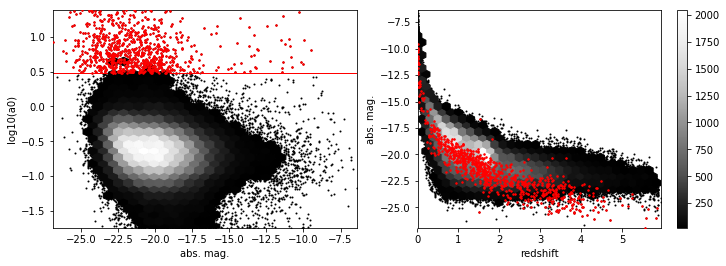

In [26]:
fig = plt.figure(figsize=[12,4])
ax1 = fig.add_subplot(121)

xval = M
yval = np.log10(a0)
plot_hexbin_scatter(ax1, xval, yval, xlabel='abs. mag.', ylabel='log10(a0)')
ax1.axhline(np.log10(a0_thresh), color='r', lw=1)

ax2 = fig.add_subplot(122)
xval = z
yval = M
hexbinout = plot_hexbin_scatter(ax2, xval, yval, xlabel='redshift', ylabel='abs. mag.')

plt.colorbar(hexbinout)

In [ ]:
#ax2.plot(np.log10(z), M-np.log10(z)*6, marker='.', ls=' ',ms=2)

### Show thumbnails for some unusually large galaxies

In [31]:
from astropy import coordinates
from astropy import units as u

In [32]:
# Read in the COSMOS mosaic
mosaic = fits.open("DATA/mosaics/hlsp_candels_hst_wfc3_cos-tot_f160w_v1_0_drz.fits")
wcsobj = WCS(mosaic[0].header)

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


In [33]:
ra_big = np.array(cat_trim['RA_GAL'][ibig])*u.degree
dec_big = np.array(cat_trim['DEC_GAL'][ibig])*u.degree
x_big, y_big = wcsobj.wcs_world2pix(ra_big, dec_big, 1)


ra = np.array(cat_trim['RA_GAL'])*u.degree
dec = np.array(cat_trim['DEC_GAL'])*u.degree
x_all, y_all = wcsobj.wcs_world2pix(ra, dec, 1)

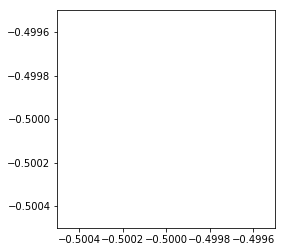

In [36]:
i=ibig[1]
x,y = int(x_all[i]), int(y_all[i])
dxy=50 # half of the stamp size
mosaic_stamp = mosaic[0].data[y-dxy:y+dxy,x-dxy:x+dxy]
plt.imshow(mosaic_stamp, vmin=-0.01, vmax=0.03)
plt.show()